In [1]:
%matplotlib inline 
import numpy as np
import pandas as pd
import scipy.stats as stats
import matplotlib.pyplot as plt
import sklearn
import statsmodels.api as sm
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn import metrics
from sklearn.grid_search import GridSearchCV
from sklearn.cross_validation import train_test_split
from sklearn.metrics import confusion_matrix

import seaborn as sns
sns.set_style("whitegrid")
sns.set_context("poster")
import warnings
warnings.filterwarnings('ignore')


from sklearn import cross_validation
from matplotlib import rcParams
from bs4 import BeautifulSoup
from pyquery import PyQuery as pq
from collections import defaultdict 
from imdb import IMDb
import pandas as pd
import cPickle as pickle
import io 
import time
import requests

from imdb import IMDb
ia = IMDb()
def get_mpaa(movieobj):
    try:
        mpaa = str(movieobj.data['mpaa']).split("Rated ", 1)[1].split(" ")[0]
    except:
        mpaa = np.nan
    return mpaa

##1. Background, Motivation and Related Work

If one were to ask most movie executives what the most important quality of their movies should be, they would probably jump to the obvious answer: "Artistic depth and quality"

...Well, perhaps obvious to the die-hard movie afficianado, but in reality, the bottom line is probably what's most pressingly on the minds of any movie-making machine.

So what strategies are most likely to make a film a box office smash? Over the coming analyses, we will explore the levers that a would-be producer might pull to maximize their sales.

Slightly differently from the Oscar analysis, there has been limited work on the questions around Movie Gross. We did consider a paper out of Stanford http://cs229.stanford.edu/proj2013/vanderMerweEimon-MaximizingMovieProfit.pdf that delves into some of the concepts we are looking to address here.

This Process Notebook outlines the following exercises performed to arrive at a results for the analysis:

1. Background, Motivation and Related Work
2. Initial Questions
3. Data Transformation: Dataframes, standardization and collation
4. Exploratory Data Analysis
5. Model Building using StatsModel
6. a. Leveraging sklearn as an alternative to StatsModel
7. b. Hyperparameter tuning using Lasso Regression in sklearn
8. Results and Conclusion




##2. Initial Questions

- **Movie Budget**: Wealth begets wealth, goes the old adage. For studios looking to make a splash, how important are the investment dollars put against a production?
- **Opening Weekend**: Film industry experts love the 'Opening Weekend' phenomenon, but just how much does the first 4 days of a movie's release truly matter?
- **Opening Theaters**: Does the scale of release during the opening weekend affect a movie?
- **IMDb rating**: Does how 'good' the movie is actually matter? We leverage the IMDb rating as a proxy for the 'inherent level of quality' of the movie. 
- **Seasonality**: How does a release around Christmas or the summer vacation affect the outcomes of a movie?
- **MPAA Rating**: For the kids, the parents, or the young adults? 
- **Power Studios**: Do movie production houses like Warner Bros. or Universal have a power of their own, besides the factors listed above?

##3. Data Transformation

In [2]:
BOdict = pickle.load(io.open('BOdict.p', 'rb'))

In [3]:
BOdf = pd.DataFrame(BOdict).transpose()

In [4]:
##Culling the dataset down to ensure we have non-null responses in our keys variables
limiteddf = BOdf.dropna(subset=['budget', 'season', 'mpaa', 'opening'])

## Ensuring that the number values are not in text format
limiteddf['gross'].replace(regex=True,inplace=True,to_replace=r'\D',value=r'')
limiteddf['opening'].replace(regex=True,inplace=True,to_replace=r'\D',value=r'')
limiteddf['opening theaters'].replace(regex=True,inplace=True,to_replace=r'\D',value=r'')

##Replacing empty values
limiteddf.loc[limiteddf['opening']=='', 'opening']  = 0
limiteddf.loc[limiteddf['opening theaters']=='', 'opening theaters']  = 0

##Converting to float values for numerical variables
limiteddf['gross'] = limiteddf['gross'].astype(float)
limiteddf['opening'] = limiteddf['opening'].astype(float)
limiteddf['opening theaters'] = limiteddf['opening theaters'].astype(float)
limiteddf['budget'] = limiteddf['budget'].astype(float)
limiteddf['rating'] = limiteddf['rating'].astype(float)

##Converting to season (as necessary)
#limiteddf.loc[limiteddf['season']==0, 'season'] = 'Jan-May'
#limiteddf.loc[limiteddf['season']==1, 'season'] = 'June-Sep'
#limiteddf.loc[limiteddf['season']==2, 'season'] = 'Oct-Nov'
#limiteddf.loc[limiteddf['season']==3, 'season'] = 'Dec'

#Creating dummy variables for the various seasons
seasonlist = limiteddf.season.unique()
for season in seasonlist:
    limiteddf[season] = limiteddf['season']==season  

# Invoking a procedure similar to get_mpaa in order to process the MPAA rating
for i in limiteddf.index:
    try:
        limiteddf.loc[i, 'mpaa_new'] = limiteddf.loc[i, 'mpaa'].split("Rated ", 1)[1].split(" ")[0]
    except:
        limiteddf.loc[i, 'mpaa_new'] = 'PG-13'
limiteddf.loc[limiteddf['mpaa_new']=='PG-', 'mpaa_new'] = 'PG'
limiteddf.loc[limiteddf['mpaa_new']=='NC-17', 'mpaa_new'] = 'R'

#Creating dummy variables for the various MPAA Ratings
mpaalist = limiteddf.mpaa_new.unique()
for mpaa in mpaalist:
    limiteddf[mpaa] = limiteddf['mpaa_new']==mpaa
    
#Creating a list of prolific studios
studiodf = limiteddf.groupby('studio') 
studioslist = studiodf['title'].count()
studioslist.sort(ascending=False)

#Identifying the top-5 studios
limiteddf['prol_studio'] = False
for i in studioslist.index[:5]:
    limiteddf.loc[limiteddf['studio']==i,'prol_studio'] = True
    
#Identifying the next 5 top studios
limiteddf['Tier_2'] = False
for i in studioslist.index[6:12]:
    limiteddf.loc[limiteddf['studio']==i,'Tier_2'] = True

#Renaming the columns for use later
limiteddf.rename(columns={'opening theaters': 'opening_theaters', 'opening': 'opening_gross'}, inplace=True)

##4. Exploratory Data Analysis

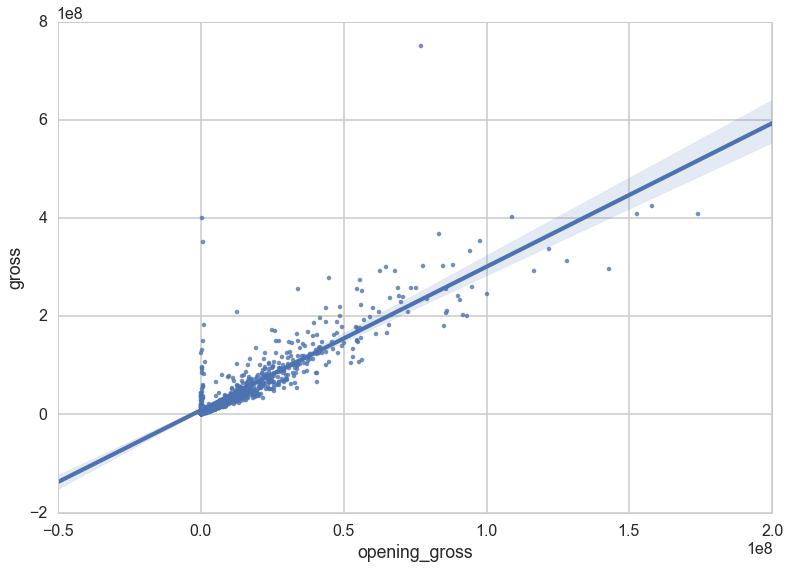

In [5]:
##This first plot examines the relationship between Gross Revenue and Opening Weekend Revenue
sns.regplot(y="gross", x="opening_gross", data=limiteddf, fit_reg = True)

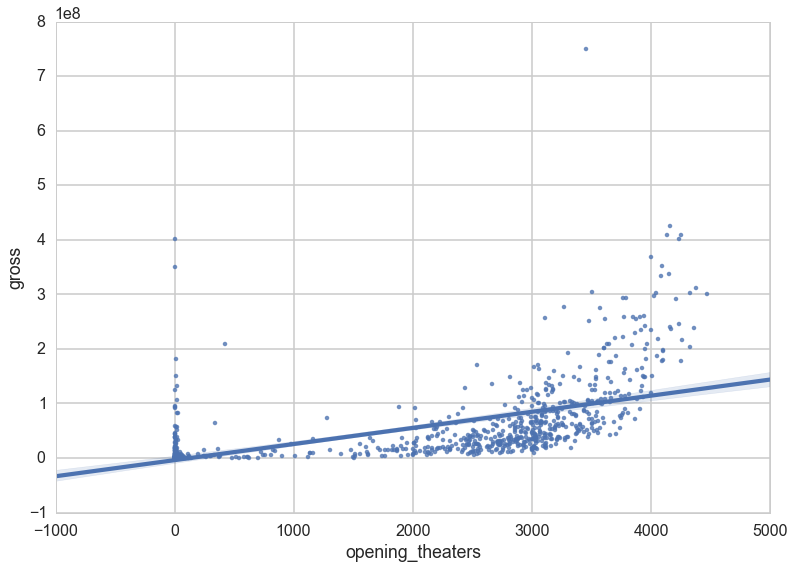

In [6]:
# The next plot examines the relationship between the gross income and # of opening theaters
sns.regplot(y="gross", x="opening_theaters", data=limiteddf, fit_reg = True)

# The plot indicates that the relationship is positive, but definitely not linear. 
# It appears to have a sharp upward curve at around 3000 theaters, which is an important
# finding for movie houses to consider

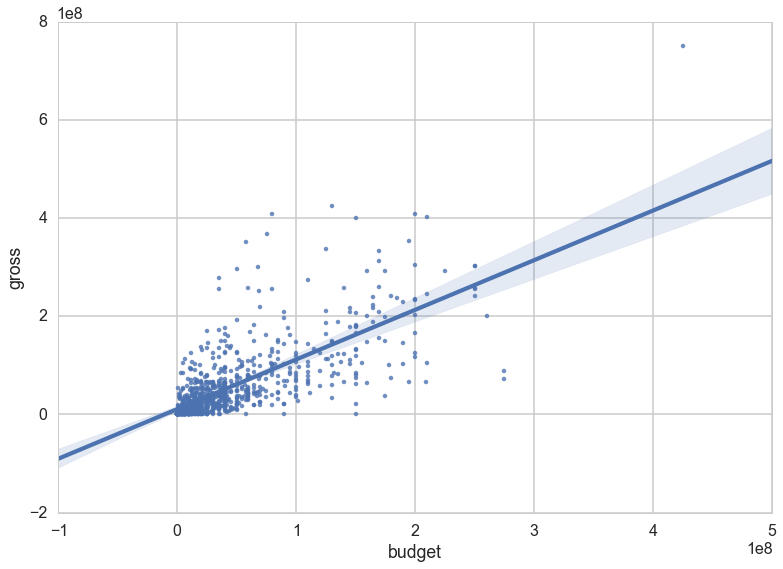

In [7]:
#This plot looks at the relationship between a movie's gross revenue and its allocated budget
sns.regplot(y="gross", x="budget", data=limiteddf, fit_reg = True)

# The relationship looks like, although there appears to be a wide disperion, especially 
# the further one goes out in revenue/budget

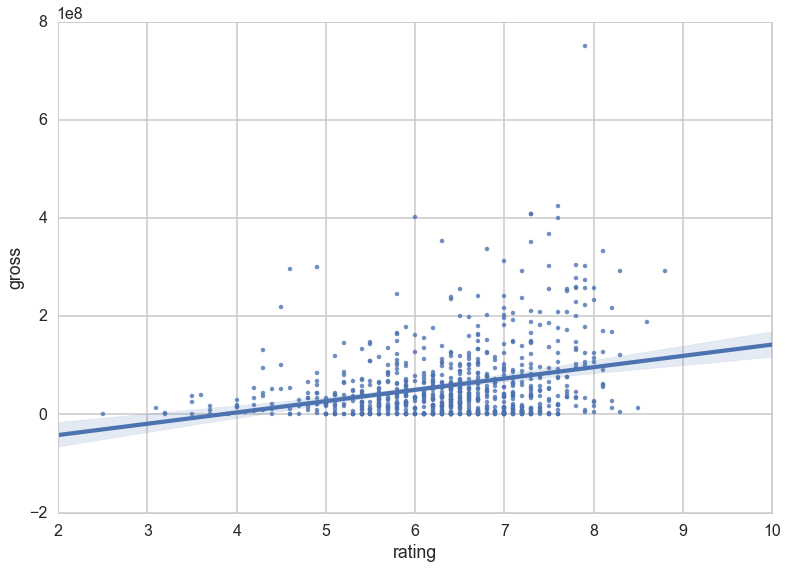

In [8]:
# The next plot looks at how the gross revenue income increases with IMDb rating
sns.regplot(y="gross", x="rating", data=limiteddf, fit_reg = True)

# While there is definitely an upward trend, it is a very flat, indicating that the revenue
# is not strongly dependent on the rating - and perhaps the quality of the movie therein 

##5. Modeling Using Statsmodel

Having explored the data to some degree, this section delves into multiple models that look at how the Gross Revenue of a movie might be associated with the factors posited at the start of this notebook.

Given the limited number of features, we believe that using Statsmodel would be the ideal tool to leverage. We do analyze whether there are any differences from the sklearn analysis.

In [9]:
# Creating train and test datasets to leverage later
itrain, itest = train_test_split(xrange(limiteddf.shape[0]), train_size=0.6)
mask=np.ones(limiteddf.shape[0], dtype='int')
mask[itrain]=1
mask[itest]=0
mask = (mask==1)

In [10]:
from statsmodels.formula.api import ols

# The first model leverages only three variables (counting season as a single variable)
m1 = ols('gross ~ budget + opening_theaters + season',limiteddf[mask]).fit()
print m1.summary()
#The R-squared associated with this analysis is about average, with plenty of unexplained variation in the data

# As an inital model, it appears to answer important questions around the role of budget

                            OLS Regression Results                            
Dep. Variable:                  gross   R-squared:                       0.540
Model:                            OLS   Adj. R-squared:                  0.535
Method:                 Least Squares   F-statistic:                     113.4
Date:                Thu, 10 Dec 2015   Prob (F-statistic):           4.29e-79
Time:                        22:27:07   Log-Likelihood:                -9416.1
No. Observations:                 489   AIC:                         1.884e+04
Df Residuals:                     483   BIC:                         1.887e+04
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [95.0% Conf. Int.]
--------------------------------------------------------------------------------------
Intercept           1.584e+07   8.95

In [11]:
m2 = ols('gross ~ budget + opening_theaters + opening_gross + season',limiteddf[mask]).fit()
print m2.summary()
#Model 2 adds in the gross revenue for the opening weekend. Once we do so,
# The coefficient on the opening theaters variable is reversed, which means that
# adding in the gross opening weekend has exposed the non-linear relationship
## Additionally, there is likely correlation between the opening weekend gross and theaters

                            OLS Regression Results                            
Dep. Variable:                  gross   R-squared:                       0.789
Model:                            OLS   Adj. R-squared:                  0.786
Method:                 Least Squares   F-statistic:                     299.6
Date:                Thu, 10 Dec 2015   Prob (F-statistic):          4.38e-159
Time:                        22:27:10   Log-Likelihood:                -9226.1
No. Observations:                 489   AIC:                         1.847e+04
Df Residuals:                     482   BIC:                         1.850e+04
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [95.0% Conf. Int.]
--------------------------------------------------------------------------------------
Intercept           4.085e+07   6.16

In [12]:
m3 = ols('gross ~ budget + opening_theaters + opening_gross + season + prol_studio + Tier_2',limiteddf[mask]).fit()
print m3.summary()
# Model 3 incorporates whether the movie was part of a big studio
# According to the results, there appears to be little effect

                            OLS Regression Results                            
Dep. Variable:                  gross   R-squared:                       0.790
Model:                            OLS   Adj. R-squared:                  0.787
Method:                 Least Squares   F-statistic:                     226.0
Date:                Thu, 10 Dec 2015   Prob (F-statistic):          1.94e-157
Time:                        22:27:11   Log-Likelihood:                -9224.1
No. Observations:                 489   AIC:                         1.847e+04
Df Residuals:                     480   BIC:                         1.850e+04
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [95.0% Conf. Int.]
---------------------------------------------------------------------------------------
Intercept            4.209e+07   6

In [13]:
m5 = ols('gross ~ budget + opening_gross + season + mpaa_new + rating + opening_theaters',limiteddf[mask]).fit()
print m5.summary()
#Model 5 (Model 4 was deprecated) appears to have the best results, with the minimum required 
# variables.

                            OLS Regression Results                            
Dep. Variable:                  gross   R-squared:                       0.804
Model:                            OLS   Adj. R-squared:                  0.800
Method:                 Least Squares   F-statistic:                     217.7
Date:                Thu, 10 Dec 2015   Prob (F-statistic):          4.77e-163
Time:                        22:27:14   Log-Likelihood:                -9208.1
No. Observations:                 489   AIC:                         1.844e+04
Df Residuals:                     479   BIC:                         1.848e+04
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [95.0% Conf. Int.]
--------------------------------------------------------------------------------------
Intercept          -8.581e+06   1.43

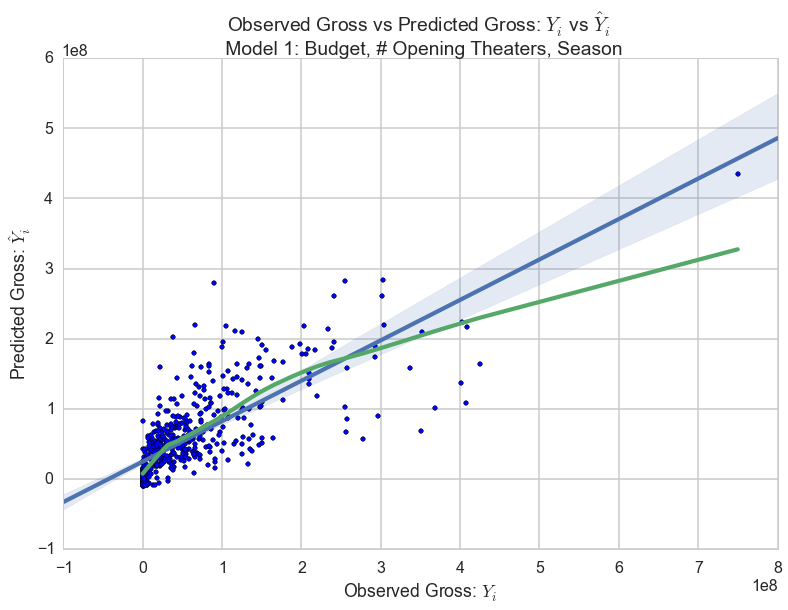

In [14]:
#We compare the results of our Model 1 to Model 5 by testing the observed vs. Predicted fits.
# The green line is a non-parametric lowess curve that attempts to be a comparison
# to help us determine how well the line of best fit describes the true nature of the data.

model1fit = zip(limiteddf[mask]['gross'],m1.fittedvalues)
m1df = pd.DataFrame(model1fit, columns=['observed gross','predicted gross'])
sns.regplot(y="predicted gross", x="observed gross", data=m1df, fit_reg = True, robust=True)
sns.regplot(y="predicted gross", x="observed gross", data=m1df, fit_reg = True, lowess=True)
plt.scatter(limiteddf[mask]['gross'], m1.fittedvalues)
plt.xlabel("Observed Gross: $Y_i$")
plt.ylabel("Predicted Gross: $\hat{Y}_i$")
plt.title("Observed Gross vs Predicted Gross: $Y_i$ vs $\hat{Y}_i$ \n Model 1: Budget, # Opening Theaters, Season")

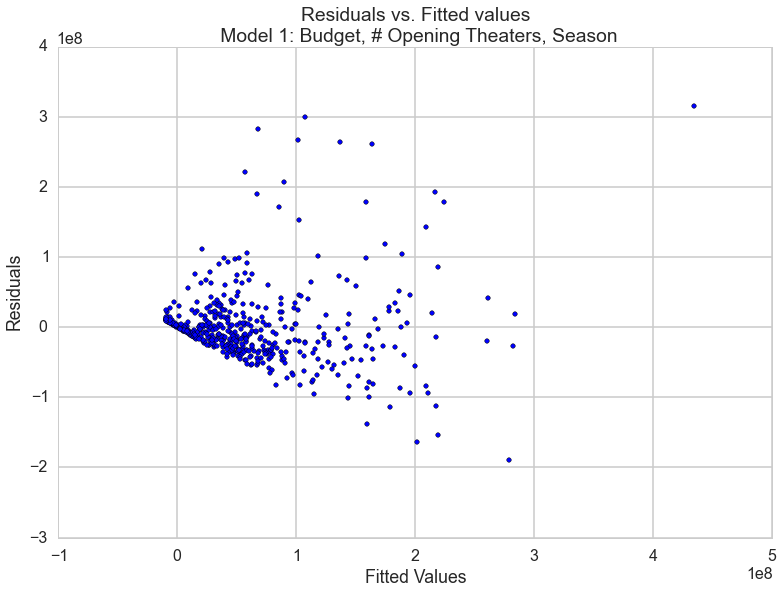

In [15]:
#Our residuals plot indicates that there is a strong 'fan' effect of heteroskedasticity
# where the error terms increase as we move further out
plt.scatter(m1.fittedvalues, limiteddf[mask]['gross'] - m1.fittedvalues)
plt.xlabel("Fitted Values")
plt.ylabel("Residuals")
plt.title("Residuals vs. Fitted values \n Model 1: Budget, # Opening Theaters, Season")

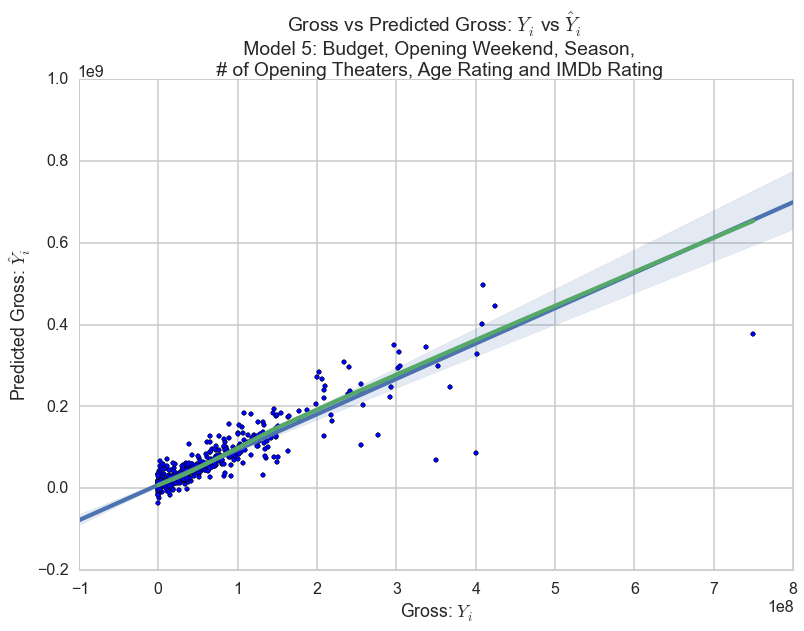

In [16]:
#Model 5 appears to be a much better fit , where we are explaining the variation far better

model5fit = zip(limiteddf[mask]['gross'],m5.fittedvalues)
m5df = pd.DataFrame(model5fit, columns=['observed gross','predicted gross'])
sns.regplot(y="predicted gross", x="observed gross", data=m5df, fit_reg = True, robust=True)
sns.regplot(y="predicted gross", x="observed gross", data=m5df, fit_reg = True, lowess=True)
plt.scatter(limiteddf[mask]['gross'], m5.fittedvalues)
plt.xlabel("Gross: $Y_i$")
plt.ylabel("Predicted Gross: $\hat{Y}_i$")
plt.title("Gross vs Predicted Gross: $Y_i$ vs $\hat{Y}_i$ \n Model 5: Budget, Opening Weekend, Season, \n # of Opening Theaters, Age Rating and IMDb Rating")


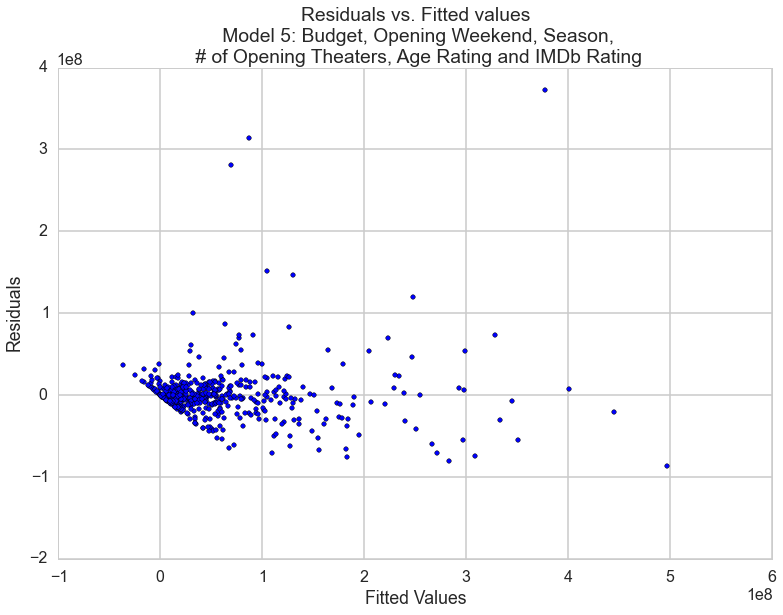

In [17]:
# The residuals have shrunk considerably in Model 5.
# There is also far less exhibited heteroskedasticity in the data.
plt.scatter(m5.fittedvalues, limiteddf[mask]['gross'] - m5.fittedvalues)
plt.xlabel("Fitted Values")
plt.ylabel("Residuals")
plt.title("Residuals vs. Fitted values \n Model 5: Budget, Opening Weekend, Season, \n # of Opening Theaters, Age Rating and IMDb Rating")

##5. Using SKlearn as an analysis alternative

In [18]:
from sklearn.linear_model import LinearRegression
# Our X design matrix contains all the covariates that we believe might be interesting to explore
X = limiteddf[['Jan-May','June-Sep','Dec', 'budget', 'opening_gross', 'opening_theaters', 'PG-13', 'R', 'rating']]

# This creates a LinearRegression object
lm = LinearRegression()


In [19]:
#We fit the outcome gross revenue variable on this model
lm.fit(X, limiteddf.gross)
print 'Estimated intercept coefficient:', lm.intercept_
print 'Number of coefficients:', len(lm.coef_)
# The coefficients
pd.DataFrame(zip(X.columns, lm.coef_), columns = ['features', 'estimatedCoefficients'])

Estimated intercept coefficient: -41884583.5891
Number of coefficients: 9


,features,estimatedCoefficients
0,Jan-May,-7498609.028921
1,June-Sep,-1018325.676897
2,Dec,23003841.684770
3,budget,0.252446
4,opening_gross,2.576551
5,opening_theaters,-2392.384013
6,PG-13,-12062973.042195
7,R,-12284924.525881
8,rating,9346158.325051


###Creating a train/test set to rework lm and calculate MSE

In [20]:
## Creating a set of training and test data
X_train, X_test, Y_train, Y_test = sklearn.cross_validation.train_test_split(
    X, limiteddf.gross, test_size=0.33, random_state = 5)
print X_train.shape
print X_test.shape
print Y_train.shape
print Y_test.shape

(546, 9)
(269, 9)
(546,)
(269,)


In [21]:
#fitting our training data to the model specified above.
lm = LinearRegression()
lm.fit(X_train, Y_train)
pred_train = lm.predict(X_train)
pred_test = lm.predict(X_test)

In [22]:
## Considering the MSE of our model on the fit versus train data
print "Fit a model X_train, and calculate MSE with Y_train:", np.mean((Y_train - lm.predict(X_train)) ** 2)
print "Fit a model X_train, and calculate MSE with X_test, Y_test:", np.mean((Y_test - lm.predict(X_test)) ** 2)
## The results do indicate that there is some difference between them, but we will
## officially check out models in the section below

Fit a model X_train, and calculate MSE with Y_train: 9.68538585437e+14
Fit a model X_train, and calculate MSE with X_test, Y_test: 1.21942178652e+15


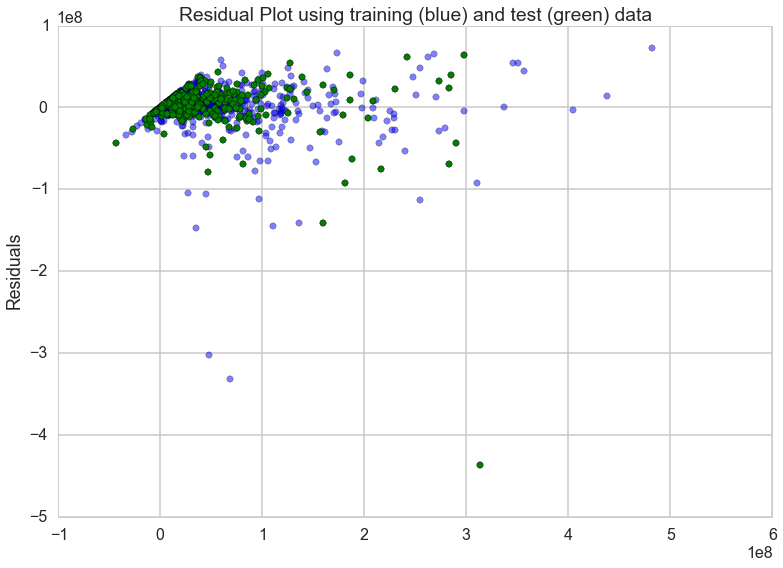

In [23]:
##Plotting the results of our model against the residuals
plt.scatter(lm.predict(X_train), lm.predict(X_train) - Y_train, c='b', s=40, alpha=0.5)
plt.scatter(lm.predict(X_test), lm.predict(X_test) - Y_test, c='g', s=40)
plt.hlines(y = 0, xmin=0, xmax = 50)
plt.title('Residual Plot using training (blue) and test (green) data')
plt.ylabel('Residuals')
## Aside from the strong clustering of data points towards the left (lower)
## end of the spectrum, there generally appears to be equally distributed residuals

##5b. Using Sklearn to analyze models of increasing complexity while continuing to tune parameters

In [24]:
## We have altered the CV_optimize functions and the do_classify functions to optimize 
## the models for our analysis
## Here do_classify is modified to be 'do_regression', but performs similar actions.

## The outcome variable has been defined for us already as Gross Revenue

## The score function employed here is Mean Squared Error, as that is commonly used in 
## linear regression models

## There are limited parameters for linear regression, and we will therefore mostly
## be employing a Lasso regression technique, which will eliminate any parameters
## that have negligible effects on the Gross Revenue outcome

def cv_optimize(regmodel, parameters, X, y, n_jobs=1, n_folds=5, score_func=None):
    if score_func:
        gs = GridSearchCV(regmodel, param_grid=parameters, cv=n_folds, n_jobs=n_jobs, scoring=score_func)
    else:
        gs = GridSearchCV(regmodel, param_grid=parameters, n_jobs=n_jobs, cv=n_folds)
    gs.fit(X, y)
    best = gs.best_estimator_
    ##Note we do not print all possible iterations of the best estimator
    return best

def do_regression(regmodel, parameters, indf, featurenames, mask=None, 
                  reuse_split=None, score_func=None, n_folds=5, n_jobs=1):
    subdf=indf[featurenames]
    X=subdf.values
    y=indf['gross']
    print "The features being evaluated in this model are:"
    print featurenames
    if mask !=None:
        print "using mask"
        Xtrain, Xtest, ytrain, ytest = X[mask], X[~mask], y[mask], y[~mask]
    if reuse_split !=None:
        print "using reuse split"
        Xtrain, Xtest, ytrain, ytest = reuse_split['Xtrain'], reuse_split['Xtest'], reuse_split['ytrain'], reuse_split['ytest']
    if parameters:
        regmodel = cv_optimize(regmodel, parameters, Xtrain, ytrain, n_jobs=n_jobs, n_folds=n_folds, score_func=score_func)
    regmodel=regmodel.fit(Xtrain, ytrain)
    training_accuracy = regmodel.score(Xtrain, ytrain)
    test_accuracy = regmodel.score(Xtest, ytest)
    print "############# based on standard predict ################"
    print "Accuracy on training data: %0.2f" % (training_accuracy)
    print "Accuracy on test data:     %0.2f" % (test_accuracy)
    print "########################################################"
    return regmodel, Xtrain, ytrain, Xtest, ytest

In [25]:
##Using a budget-only model as the baseline

reg_1 = Lasso()

# The parameters being tuned are those specific to Lasso, in particular we expect only the 
# Tolerance parameter to have any effect on the outcomes
parameters = {"fit_intercept": [True, False], "normalize":[True, False], 
              "copy_X":[True, False], "max_iter":[10,100,1000],
             "tol": [0.0001,0.001, 0.00001,0.01]}
reg_1, Xtrain, ytrain, Xtest, ytest=do_regression(reg_1, parameters, limiteddf, ['budget'], mask=mask, score_func = 'r2')

The features being evaluated in this model are:
['budget']
using mask
############# based on standard predict ################
Accuracy on training data: 0.54
Accuracy on test data:     0.46
########################################################


In [26]:
##Incorporating the # of Openings theaters as an additional predictor

reg_2 = Lasso()
parameters = {"fit_intercept": [True, False], "normalize":[True, False], "copy_X":[True, False], "max_iter":[10,100,1000],
             "tol": [0.0001,0.001, 0.00001,0.01]}
reg_2, Xtrain, ytrain, Xtest, ytest=do_regression(reg_2, parameters, limiteddf, ['budget', 'opening_theaters'], mask=mask, score_func = 'mean_squared_error')

The features being evaluated in this model are:
['budget', 'opening_theaters']
using mask
############# based on standard predict ################
Accuracy on training data: 0.56
Accuracy on test data:     0.50
########################################################


In [27]:
##Incorporating Opening Weekend Gross

reg_3 = Lasso()
parameters = {"fit_intercept": [True, False], "normalize":[True, False], "copy_X":[True, False], "max_iter":[10,100,1000],
             "tol": [0.0001,0.001, 0.00001,0.01]}
reg_3, Xtrain, ytrain, Xtest, ytest=do_regression(reg_3, parameters, limiteddf, ['budget', 'opening_theaters', 'opening_gross'], mask=mask, score_func = 'mean_squared_error')

The features being evaluated in this model are:
['budget', 'opening_theaters', 'opening_gross']
using mask
############# based on standard predict ################
Accuracy on training data: 0.75
Accuracy on test data:     0.85
########################################################


In [28]:
#This version incorporates the season that the movie was released in

reg_4 = Lasso()
parameters = {"fit_intercept": [True, False], "normalize":[True, False], "copy_X":[True, False], "max_iter":[10,100,1000],
             "tol": [0.0001,0.001, 0.01]}
reg_4, Xtrain, ytrain, Xtest, ytest=do_regression(reg_4, parameters, limiteddf, ['Jan-May', 'June-Sep', 'Dec', 'budget', 'opening_gross', 'opening_theaters'], mask=mask, score_func = 'mean_squared_error')

The features being evaluated in this model are:
['Jan-May', 'June-Sep', 'Dec', 'budget', 'opening_gross', 'opening_theaters']
using mask
############# based on standard predict ################
Accuracy on training data: 0.77
Accuracy on test data:     0.86
########################################################


In [29]:
# This includes the studio, in the form of 'prol_studio' which measures if the studio is 
# in the top 5 prolific studios in the country

reg_5 = Lasso()
parameters = {"fit_intercept": [True, False], "normalize":[True, False], "copy_X":[True, False], "max_iter":[10,100,1000],
             "tol": [0.0001,0.001, 0.01]}
reg_5, Xtrain, ytrain, Xtest, ytest=do_regression(reg_5, parameters, limiteddf, ['prol_studio', 'Jan-May', 'June-Sep', 'Dec', 'budget', 'opening_gross', 'opening_theaters'], mask=mask, score_func = 'mean_squared_error')

The features being evaluated in this model are:
['prol_studio', 'Jan-May', 'June-Sep', 'Dec', 'budget', 'opening_gross', 'opening_theaters']
using mask
############# based on standard predict ################
Accuracy on training data: 0.77
Accuracy on test data:     0.85
########################################################


In [30]:
#With Tier_2 studio added in there to see if the movie belonging to any
# of the top 10 studios has an effect

reg_6 = Lasso()
parameters = {"fit_intercept": [True, False], "normalize":[True, False], "copy_X":[True, False], "max_iter":[10,100,1000],
             "tol": [0.0001,0.001, 0.01]}
reg_6, Xtrain, ytrain, Xtest, ytest=do_regression(reg_6, parameters, limiteddf, ['prol_studio','Tier_2', 'Jan-May', 'June-Sep', 'Oct-Nov', 'budget', 'opening_gross', 'opening_theaters'], mask=mask, score_func = 'mean_squared_error')

The features being evaluated in this model are:
['prol_studio', 'Tier_2', 'Jan-May', 'June-Sep', 'Oct-Nov', 'budget', 'opening_gross', 'opening_theaters']
using mask
############# based on standard predict ################
Accuracy on training data: 0.77
Accuracy on test data:     0.85
########################################################


In [31]:
#With MPAA Rating included in the model

reg_7 = Lasso()
parameters = {"fit_intercept": [True, False], "normalize":[True, False], "copy_X":[True, False], "max_iter":[10,100,1000],
             "tol": [0.0001,0.001, 0.01]}
reg_7, Xtrain, ytrain, Xtest, ytest=do_regression(reg_7, parameters, limiteddf, [ 'Jan-May', 'June-Sep', 'Oct-Nov', 'budget', 'opening_gross', 'opening_theaters','prol_studio','Tier_2', 'PG-13', 'R'], mask=mask, score_func = 'mean_squared_error')

The features being evaluated in this model are:
['Jan-May', 'June-Sep', 'Oct-Nov', 'budget', 'opening_gross', 'opening_theaters', 'prol_studio', 'Tier_2', 'PG-13', 'R']
using mask
############# based on standard predict ################
Accuracy on training data: 0.78
Accuracy on test data:     0.85
########################################################


In [32]:
#With IMDb Movie Rating included

reg_8 = Lasso()
parameters = {"fit_intercept": [True, False], "normalize":[True, False], "copy_X":[True, False], "max_iter":[10,100,1000],
             "tol": [0.0001,0.001, 0.01]}
reg_8, Xtrain, ytrain, Xtest, ytest=do_regression(reg_8, parameters, limiteddf, [ 'Jan-May', 'June-Sep', 'Oct-Nov', 'budget', 'opening_gross', 'opening_theaters', 'PG-13', 'R', 'rating'], mask=mask, score_func = 'mean_squared_error')

The features being evaluated in this model are:
['Jan-May', 'June-Sep', 'Oct-Nov', 'budget', 'opening_gross', 'opening_theaters', 'PG-13', 'R', 'rating']
using mask
############# based on standard predict ################
Accuracy on training data: 0.79
Accuracy on test data:     0.87
########################################################


In [33]:
## Having attained the model we believe to be the best fit of our data, we can
## compare the output to that received from the Statsmodel analysis
from sklearn.feature_selection import chi2
scores, pvalues = chi2(Xtrain, ytrain)

In [34]:
## This compiles the results from the sklearn variable
print 'Estimated intercept coefficient:', reg_8.intercept_
print 'Number of coefficients:', len(reg_8.coef_)
# The coefficients
print reg_8.intercept_
pd.DataFrame(zip(['Jan-May', 'June-Sep', 'Oct-Nov', 'budget', 'opening_gross', 'opening_theaters', 'PG-13','R', 'rating'], reg_8.coef_, scores, pvalues), columns = ['features', 'estimatedCoefficients', 'scores', 'pvalues'])

Estimated intercept coefficient: -14580145.5087
Number of coefficients: 9
-14580145.5087


,features,estimatedCoefficients,scores,pvalues
0,Jan-May,-35554141.458144,3.320000e+02,1.00000
1,June-Sep,-30490060.235017,3.100000e+02,1.00000
2,Oct-Nov,-27568911.500927,3.920000e+02,0.99948
3,budget,0.324626,3.049301e+10,0.00000
4,opening_gross,2.447496,1.427538e+10,0.00000
5,opening_theaters,-3027.212882,4.760421e+05,0.00000
6,PG-13,-16787065.858001,2.940000e+02,1.00000
7,R,-15760045.883677,2.760000e+02,1.00000
8,rating,10134856.484621,7.000449e+01,1.00000


In [18]:
#Reporting the results from our last Statsmodel version, m5.
m5.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  gross   R-squared:                       0.804
Model:                            OLS   Adj. R-squared:                  0.800
Method:                 Least Squares   F-statistic:                     217.7
Date:                Thu, 10 Dec 2015   Prob (F-statistic):          4.77e-163
Time:                        22:27:55   Log-Likelihood:                -9208.1
No. Observations:                 489   AIC:                         1.844e+04
Df Residuals:                     479   BIC:                         1.848e+04
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [95.0% Conf. Int.]
--------------------------------------------------------------------------------------
Intercept          -8.581e+06   1.43e+07     -0.601      0.548     -3.67e+07  1.95e+07
season[T.Jan-May]  -3.879e+07   6.45e+06     -6.014      0.000     -5.15e+07 -2.61e+07
season[T.June-Sep] -3.329e+07   6.21e+06     -5.360      0.000     -4.55e+07 -2.11e+07
season[T.Oct-Nov]  -2.841e+07   6.72e+06     -4.230      0.000     -4.16e+07 -1.52e+07
mpaa_new[T.PG-13]  -1.523e+07   4.87e+06     -3.126      0.002     -2.48e+07 -5.65e+06
mpaa_new[T.R]      -1.231e+07   5.05e+06     -2.437      0.015     -2.22e+07 -2.38e+06
budget                 0.3482      0.044      7.882      0.000         0.261     0.435
opening_gross          2.5252      0.108     23.377      0.000         2.313     2.737
rating               9.39e+06   1.85e+06      5.074      0.000      5.75e+06   1.3e+07
opening_theaters   -4440.8458   1717.860     -2.585      0.010     -7816.318 -1065.374
==============================================================================
Omnibus:                      521.385   Durbin-Watson:                   1.978
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            34511.391
Skew:                           4.714   Prob(JB):                         0.00
Kurtosis:                      43.062   Cond. No.                     7.23e+08
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 7.23e+08. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

#Results and Conclusions

The series of analyses conducted over the course of this section of the project have yielded interesting results, and we discuss the ramifications of those outputs here:

- The 'budget' variable is both statistically signficant and meaningful. The coefficient of about 0.3 indicates that every dollar in the budget entails 30 cents of revenue. This means that simply throwing money at a movie in the hopes that it works is not a wise strategy, and the other factors in the model are very important in ensuring that a movie does financially well.

- The coefficients on all the season variables indicates are negative, which means that the holdout month - December - appears to be associated with the best results for a movie's release, with movies being released during that month having an average 20M dollar boost compared to other seasons.

- The movie's MPAA rating also seems to matter, with both PG-13 and R-rated movies performing worse than their G-rated counterparts. The magnitude of the difference, controlling for all other factors, is about 18M dollars.

- The gross during the opening weekend is highly associated with the amount that the movie ends up making, with a coefficient of 2.7 this would emphasize the need to start off with a bang.

- The opening theaters variable is only moderately statistically significant, and it would actually decrease the gross revenue if there were more theaters. We do not believe this variable to be accurate, not only because of the significance, but also because it likely exhibits multicollinearity with other covariates in the model.

- The IMDb rating of the movie has a distinct, but muted, effect on the fiscal outcomes of a movie. According to the results, increasing an entire rating-point on the IMDb scale is associated with only a 10 million dollar increase in revenue. Inasmuch as our rating variable captures the 'true' quality of a movie, that is not a particularly encouraging sign for where the focus of the movie production houses lie.
